## Terzaghi problem: consolidation of a 2D poroelastic bar under compression

### Problem description

A 2D specimen composed of a poroelastic material and saturated with fluid at time zero undergoes uniaxial compression. While the upper surface is allowed to drain, the other sides are sealed. At the moment when the loading is applied, the specimen exhibit undrained behaviour: pressure homogeneously rises across the entire specimen and the specimen deforms insignificantly. When time passes, the pressure starts to diffuse from the upper surface leading to its gradual reduction from the top to the bottom. The pressure drop leads to softening of the material and increase in the vertical deformations. At the infinite time, pressure fully diffuses and the specimen is deformed according to its drained elastic properties.

Numerical solution of the coupled Terzaghi problem is compared with the analytical solution available in literature (i.e. in the book Poroelasticity of Cheng, p.228) 

![sphere](./images/terzaghi.png)

We first load all the necessary modules

In [1]:
import akantu as aka
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import gmsh
import sys

from akantu_geomechanical_solver import AkantuGeomechanicalSolver
from akantu_geomechanical_solver import IterativeOptions
sys.path.append(os.path.join(sys.path[0], '..', 'analytical_solutions'))
import analytical_solutions as an_sol

Defining geometry and material parameters

In [2]:
# geometric parameters
W = 0.1     # width (x-axis)
H = 1     # length (y-axis)
nw = 1   # number of elements in width
nh = 10   # number of elements in height

# material parameters
phi_0 = 0.05  # porosity
K = 10e9  # [Pa] bulk modulus
G = 6e9  # [Pa] shear modulus consistent with K and Poisson
poisson = (3*K - 2*G)/2/(3*K + G) # [-] Poisson ratio
E = 9*K*G/(3*K + G) # [Pa] Young modulus
alpha = 0.9  # [-] Biot's coefficient
one_over_M = 3.05e-11  # [1/Pa] Biot modulus
k = 1e-18  # [m2] matrix permeability
mu = 8.9e-4  # [Pa⋅s] fluid viscosity 
load = -5e9  # [Pa] load on top
rho_f = 1000  # [kg/m3] fluid density
rho_s = 2000  # [kg/m3] solid density
t_star = [0, 0.01, 0.1, 0.5, 1]  # [] dimensionless time
nu = alpha * (1 - 2 * poisson) / 2 / (1 - poisson) # poroelastic stress coefficient (Cheng's solution)
S = one_over_M + 3 * alpha**2 / (3*K + 4*G) # storage coefficient
c_v = k / mu / S # generalized consolidation coefficient (Cheng's book, p.198)
output_times = H*H * np.array(t_star) / c_v  # [s] real time
timestep = output_times[1]/10 # [s] time step for the solver is taken sufficiently small to capture early-time solution

### Creating a material file for Akantu

In this tutorial we will consider an poroelastic constitutive law.

The following file *material.dat* describes such a constitutive law, which we write and then load thanks to *Akantu*'s parsing routines.

In [3]:
material_file = f"""
material elastic [
    name = rock
    E   = {E}   # young's modulus
    nu  = {poisson}      # poisson's ratio
]

model heat_transfer_model [
         density = 1  #kg/m3
         conductivity = [[{k/mu}, 0, 0], \
                        [0,  {k/mu}, 0], \
                        [0,  0, {k/mu}]] # m2/(Pa s)
         capacity = {one_over_M}        # 1/Pa
]
"""
# writing the material file
open('material.dat', 'w').write(material_file)
#reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

### Creating a discretization mesh

This part of the tutorial provides a geometric description (with Gmsh syntax) of the domain to model.

*Gmsh* mesher will therefore be employed to generate a triangular mesh loadable with Akantu. 

### Producing a mesh

In [4]:
gmsh.initialize()

gmsh.model.add("transfinite_rectangle")

lc = 1e-1
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(W, 0, 0, lc, 2)
gmsh.model.geo.addPoint(W, H, 0, lc, 3)
gmsh.model.geo.addPoint(0, H, 0, lc, 4)
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.addPhysicalGroup(1, [1], name = "bottom")
gmsh.model.addPhysicalGroup(1, [3], name = "top")
gmsh.model.addPhysicalGroup(1, [4], name = "left")
gmsh.model.addPhysicalGroup(1, [2], name = "right")
gmsh.model.addPhysicalGroup(2, [1], name = "rectangle")

gmsh.model.geo.mesh.setTransfiniteCurve(1, nw + 1)
gmsh.model.geo.mesh.setTransfiniteCurve(3, nw + 1)
gmsh.model.geo.mesh.setTransfiniteCurve(2, nh + 1)
gmsh.model.geo.mesh.setTransfiniteCurve(4, nh + 1)

# The way triangles are generated can be controlled by specifying "Left",
# "Right" or "Alternate" in `setTransfiniteSurface()' command.
gmsh.model.geo.mesh.setTransfiniteSurface(1, "Left", [1, 2, 3, 4])

gmsh.model.geo.synchronize()

# Finally we apply an elliptic smoother to the grid to have a more regular
# mesh:
gmsh.option.setNumber("Mesh.Smoothing", 100)

gmsh.model.mesh.generate(2)
gmsh.write("rectangle.msh")

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000121625s, CPU 0.000176s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 7.225e-05s, CPU 5.2e-05s)
Info    : 22 nodes 46 elements
Info    : Writing 'rectangle.msh'...
Info    : Done writing 'rectangle.msh'


### Reading the mesh with Akantu

We specify the dimension and filename of the mesh to load.

In [5]:
dim = 2    
mesh_file = 'rectangle.msh'
mesh = aka.Mesh(dim)
mesh.read(mesh_file)

We extract node coordinates and their connectivity to plot with Triangulation function.

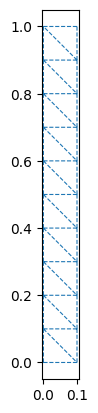

In [6]:
# extract the mesh connectivity of triangle elements
conn = mesh.getConnectivity(aka._triangle_3)
nodes = mesh.getNodes()
triangles = tri.Triangulation(nodes[:, 0], nodes[:, 1], conn)
plt.axes().set_aspect('equal')
t = plt.triplot(triangles, '--', lw=.8)

### Creating models
We create *SolidMechanicsModel* and *HeatTransferModel*. The name *HeatTransferModel* is a legacy feature of Akantu. By this name any model governed by the diffusion equation is meant. In our case, it is the pressure diffusion. Consequently, the native variable of the *HeatTransferModel* and *HeatTransferInterfaceModel* is temperature. We however understand that for the pressure diffusion, the primary variable is pressure. This inconsitency in names is expected to be corrected in future versions of Akantu.
 
*SolidMechanicsModel* and *HeatTransferModel* will be coupled through the geomechanic solver.

In [7]:
# creating the rock model
rock_model = aka.SolidMechanicsModel(mesh)
# creating the flow model
flow_model = aka.HeatTransferModel(mesh)

### Associating a static solver to rock and transient to flow

In [8]:
rock_model.initFull(_analysis_method=aka._static)
flow_model.initFull(_analysis_method=aka._implicit_dynamic)
flow_model.setTimeStep(timestep)

### Declaring boundary conditions
We first set the BCs for the mechanical problem. This is done by fixing horizontal displacements of the left and right side of the bar and vertical displacement of the bottom. We also apply vertical traction on the upper surface.

In [9]:
# set the displacement/Dirichlet boundary conditions
rock_model.applyBC(aka.FixedValue(0.0, aka._x), "left")
rock_model.applyBC(aka.FixedValue(0.0, aka._x), "right")
rock_model.applyBC(aka.FixedValue(0.0, aka._y), "bottom")

# set the force/Neumann boundary conditions
traction = [0, load] # Pa
rock_model.applyBC(aka.FromTraction(traction), "top")

## Setting up solvers

In [10]:
# configure the linear algebra solver
flow_solver = flow_model.getNonLinearSolver()
flow_solver.set("max_iterations", 10)
flow_solver.set("threshold", 1e-8) # pressure has different order of magnitude than u
flow_solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

rock_solver = rock_model.getNonLinearSolver()
rock_solver.set("max_iterations", 2)
rock_solver.set("threshold", 1e-8)
rock_solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

### Setup geomechanical solver

In [11]:
it_options = IterativeOptions(
    pcg_maxiterations=50,
    newton_maxiterations=100,
    f_rtol=1e-4,
    f_rock_tol=1e-8,
    f_flow_tol=1e-8)
solver = AkantuGeomechanicalSolver(
    rock_model, flow_model, alpha, dump_iterations=False, update_stiffness=False)

### Prepare arrays for output
Here we track only the pressure along the bar height.

In [12]:
nodes = mesh.getNodes()
node_height_dict = {}
for node_num, coords in enumerate(nodes):
    if coords[0] == 0:
        node_height_dict.update({node_num:coords[1]})
sorted_node_height = sorted(node_height_dict.items(), key=lambda x:x[1])
sorted_dict = dict(sorted_node_height)
node_height = np.array(list(sorted_dict.values()))
pres_node_ids = np.array(list(sorted_dict.keys()))
pressure_output = np.zeros((len(node_height), len(output_times)))

### Solve the undrained response
Here, we assign the exact value of the undrained pressure to the specimen and solve for the deformations. 

In [13]:
p_0_an = an_sol.p_0_terzaghi(nu, G, S, load)

# apply the analytical solution for pressure of the undrained response to the model
pressure = flow_model.getTemperature()
pressure.fill(p_0_an)
pressure_output[:, 0] = flow_model.getTemperature()[pres_node_ids][:,0]

# fix the pressure degrees of freedom for the undrained solve
blocked_dofs_p = flow_model.getBlockedDOFs()
blocked_dofs_p.fill(True)

# prepare the initial guess arrays for the PCG solver
nb_nodes = mesh.getNbNodes()
delta_u_0 = np.zeros([nb_nodes, dim])
delta_p_0 = np.zeros([nb_nodes, 1])

# solve the displacement part of the undrained response first
cvged = solver.solve_step(delta_u_0, delta_p_0, it_options)
if not cvged:
    raise Exception(
        f"Time step solver did not converge")


Newton 0 iteration: p res 0.0 vs 1e-08; u res 142826204.14695162 vs 1e-08; u res full 1323718724.5734494

iteration 0 
r2 0.0 vs. max[r0 3.285253685587808e-05 * 0.0001, rtol 1e-08] 
dx2 0.0

Newton 1 iteration: p res 0.0 vs 1e-08; u res 1.1483566121417864e-06 vs 132371.87245734496; delta u norm 0.3113836101752033; delta p norm 0.0


### Boundary conditions for the flow model
Class below defines a functor to fix scalar variable. It had to be defined here as there is no such native functor in Akantu.

In [14]:
class FixedPressure (aka.DirichletFunctor):
    def __init__(self, value):
        super().__init__()
        self.value = value

    def __call__(self, node, flags, primal, coord):
        # sets the blocked dofs vector to true in the desired axis
        flags[0] = True
        primal[0] = self.value

Here, we unfix pressure degrees of freedom and fix pressure to zero at the top of the specimen.

In [15]:
blocked_dofs_p.fill(False)
flow_model.applyBC(FixedPressure(0.), "top")

We solve the problem in the time loop. We dump pressure only at the output times.

In [16]:
 
t = 0.
i = 0
j = 0
while t < output_times[-1]:
    print(f"\nSolving time step {j}", flush=True)

    cvged = solver.solve_step(delta_u_0, delta_p_0, it_options)
    if not cvged:
        raise Exception(
            f"Time step solver did not converge")

    # recording solutions for plotting
    if np.isclose((t - output_times[i + 1]), 0):
        pressure_output[:, i + 1] = pressure[pres_node_ids][:,0]
        i += 1
    t += timestep
    j += 1


Solving time step 0

Newton 0 iteration: p res 2.630801328908933e-06 vs 1e-08; u res 157066771.20041642 vs 1e-08; u res full 1601622271.2850926

iteration 0 
r2 1.2585730463891476e-07 vs. max[r0 7.151447356150399e-06 * 0.0001, rtol 1e-08] 
dx2 411848308.69326633

iteration 1 
r2 3.1239768252487974e-08 vs. max[r0 7.151447356150399e-06 * 0.0001, rtol 1e-08] 
dx2 28406432.179043304

iteration 2 
r2 1.106647531398865e-09 vs. max[r0 7.151447356150399e-06 * 0.0001, rtol 1e-08] 
dx2 7922801.395552498

Newton 1 iteration: p res 1.1066475313986055e-09 vs 1e-08; u res 5.640832552536637e-07 vs 160162.22712850926; delta u norm 0.010731789251425638; delta p norm 415116278.5698414

Solving time step 1

Newton 0 iteration: p res 3.1010532790566003e-06 vs 1e-08; u res 5.640832552536637e-07 vs 1e-08; u res full 1607078050.532273

iteration 0 
r2 2.8792923515235903e-07 vs. max[r0 4.149082394396602e-06 * 0.0001, rtol 1e-08] 
dx2 707649886.7982727

iteration 1 
r2 7.039682617885516e-08 vs. max[r0 4.14908

We get the analytical solution for the drained pressure response.

In [17]:
p_an = an_sol.p_terzaghi(node_height,output_times[1:],H,c_v,p_0_an,200)

 ### Plotting pressure results in time

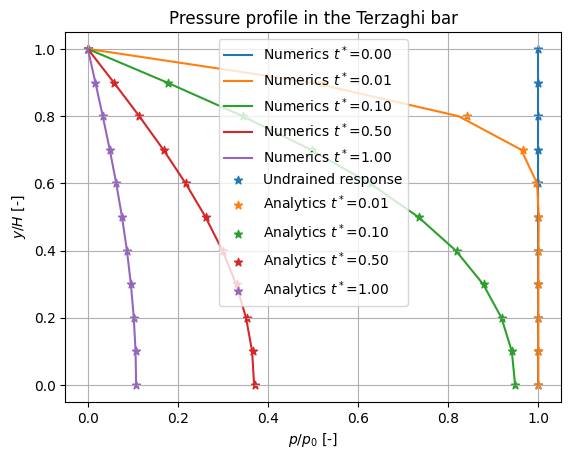

In [18]:
plt.figure()
for col, ti in zip(pressure_output.T, t_star):
    plt.plot(col/p_0_an, node_height/H, label= r'Numerics $t^*$={:.2f}'.format(ti))
plt.scatter(np.full(len(node_height), 1), node_height/H, marker='*', label= 'Undrained response')
for col, ti in zip(p_an.T, t_star[1:]):
    plt.scatter( col/p_0_an, node_height/H, marker='*', label= r'Analytics $t^*$={:.2f}'.format(ti))
plt.ylabel(r'$y/H$ [-]')
plt.xlabel(r'$p/p_0$ [-]')
plt.title('Pressure profile in the Terzaghi bar')
plt.legend()
plt.grid()
plt.show()

## Closing remarks:
1. Coupled geomechanical solver successfully solves Terzaghi problem and predicts pressure evolution in time.
2. Timestep has to be chosen sufficiently small to capture the early-time pressure solution.
3. One layer of elements in width is sufficient to reliably predict pressure. 